# Initial Visualizations of our Topic

## Loading packages and Data

Two datasets will help us do some visualization of police killings and Black Lives Matter related quotes.

- We have a shape file of the United States found at: https://www.census.gov/geographies/mapping-files/time-series/geo/cartographic-boundary.html.

- We have a dataset containing every single civilian killed by police since 2015 with demographic data.

In [1]:
#IMPORT LIBRARIES
import glob
import spacy
import numpy as np
import pandas as pd
import datetime as dt
from PIL import Image
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
%matplotlib inline
from shapely.geometry import Point, Polygon
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [2]:
USA_FILE = 'cb_2020_us_all_5m/cb_2020_us_state_5m/cb_2020_us_state_5m.shp'
POLICE_KILLINGS_FILE = 'fatal-police-shootings-data.csv'

## Creating the Dataframes for Police Killings

We create dataframes from each dataset 

In [3]:
usa_df = gpd.read_file(USA_FILE)
killings_df = pd.read_csv(POLICE_KILLINGS_FILE)
killings_df['date'] = killings_df.date.astype('datetime64').dt.date # convert date to datetime

We want to visualize killings on the map of the United States but the presence of Alaska and Hawaii may not be necessary. It would be easier to visualize just on the continental US. Let's see what portion of the data are in these states.

In [4]:
# finding percentage of killings in Alaska and Hawaii
total_killings = len(killings_df)
killings_alaska = len(killings_df[killings_df.state == 'AK'])
killings_hawaii = len(killings_df[killings_df.state == 'HI'])
print(f'Killings in Alaska and Hawaii make up {round((killings_alaska+killings_hawaii)*100/total_killings,2)} % of total killings')

Killings in Alaska and Hawaii make up 1.23 % of total killings


In [5]:
# removing Alaska and Hawaii for better view of continental US since they make up only a small percentage of killings.
usa_df = usa_df[usa_df.NAME!= "Alaska"]
usa_df = usa_df[usa_df.NAME!= "Hawaii"]
killings_df = killings_df[killings_df.state != 'AK']
killings_df = killings_df[killings_df.state != 'HI']

Now we create a dataset of civilians that were unarmed at the time of their killing. Although armed individuals also did not deserve to be killed, the fact that we have so many killings of unarmed individuals is more alarming.

In [6]:
unarmed_df = killings_df[killings_df.armed == 'unarmed'] # get a new dataframe of victims that were unarmed
unarmed_df = unarmed_df.sort_values(by = ['date'], axis = 0) # sort killings by date

In [7]:
# percentage of all unarmed killings for each race
pers = round(100*unarmed_df.groupby('race').race.count()/unarmed_df.groupby('race').race.count().sum())
print(f'Of all killings where the individual was unarmed, {pers[1]} % were Black, {pers[5]} % White, {pers[0]} % Asian, {pers[2]} % Hispanic {pers[3]} % Native American, and {pers[4]} % Other.')

Of all killings where the individual was unarmed, 34.0 % were Black, 42.0 % White, 1.0 % Asian, 20.0 % Hispanic 1.0 % Native American, and 1.0 % Other.


# Visualization of Police Killings

Let's take a look at the police killings by state.

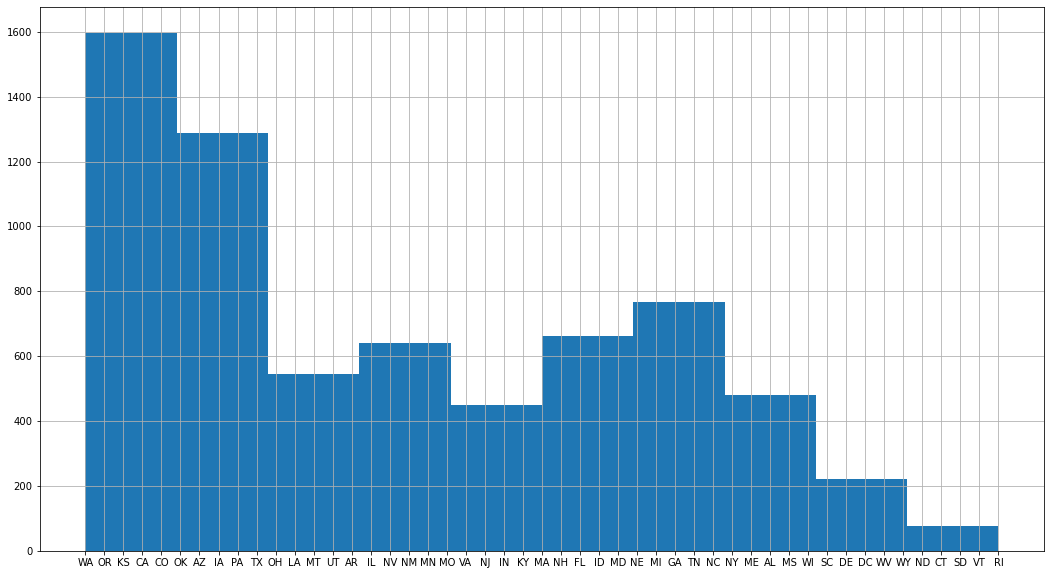

In [8]:
plt.figure(figsize=(18,10))
killings_df.state.hist() # histogram of killings by state
plt.show()

There are big differences in amount of killings by state, but since state populations and size also vary a lot, we will look at other information.

In [9]:
# here creating images of deaths of unarmed civilians on the map by day
'''
for i in range(1,len(unarmed_df)):
    fig = plt.figure(figsize = (15,10))
    axs = fig.add_subplot(1,1,1)
    usa_df.plot(ax = axs, alpha = 0.5)
    temp = unarmed_df[0:i]
    black = temp[temp.race == 'B'].plot(x = 'longitude',y = 'latitude', kind = 'scatter',
                                                  ax = axs,color = 'k', label = 'Black')
    white = temp[temp.race == 'W'].plot(x = 'longitude',y = 'latitude', kind = 'scatter',
                                                  ax = axs,color = 'r', label = 'White')
    
    other = temp[(temp.race != 'B') & (data[0:i].race != 'W')].plot(x = 'longitude',y = 'latitude', 
                        kind = 'scatter', ax = axs,color = 'b', label = 'Other')

    axs.set_title(f'Unarmed Civilians Killed by Police Officers Starting January 2015')
    num_black = temp[temp.race == 'B'].race.count()
    total = temp.race.count()
    axs.annotate(f'Date: {temp.date.iloc[-1]}\n{round(num_black*100/total,2)} % Black Deaths',xy=(0.1, 0.2),  xycoords='figure fraction', 
            horizontalalignment='left', verticalalignment='top', fontsize=12, color='k')

    axs.set_xlim(-125,-66)
    axs.set_ylim(25,50)
    axs.axis('off')
    plt.close(fig)
    fig.savefig(f'generated/map_{temp.date.iloc[-1]}',dpi=300, bbox_inches='tight',transparent= True)
    
'''

"\nfor i in range(1,len(unarmed_df)):\n    fig = plt.figure(figsize = (15,10))\n    axs = fig.add_subplot(1,1,1)\n    usa_df.plot(ax = axs, alpha = 0.5)\n    temp = unarmed_df[0:i]\n    black = temp[temp.race == 'B'].plot(x = 'longitude',y = 'latitude', kind = 'scatter',\n                                                  ax = axs,color = 'k', label = 'Black')\n    white = temp[temp.race == 'W'].plot(x = 'longitude',y = 'latitude', kind = 'scatter',\n                                                  ax = axs,color = 'r', label = 'White')\n    \n    other = temp[(temp.race != 'B') & (data[0:i].race != 'W')].plot(x = 'longitude',y = 'latitude', \n                        kind = 'scatter', ax = axs,color = 'b', label = 'Other')\n\n    axs.set_title(f'Unarmed Civilians Killed by Police Officers Starting January 2015')\n    num_black = temp[temp.race == 'B'].race.count()\n    total = temp.race.count()\n    axs.annotate(f'Date: {temp.date.iloc[-1]}\n{round(num_black*100/total,2)} % Black Death

In [10]:
# putting all the images together to create a gif
'''
# Create the frames
frames = []
imgs = glob.glob("generated/*.png")
imgs.sort()
for i in imgs:
    new_frame = Image.open(i)
    frames.append(new_frame)
 
# Save into a GIF file that loops forever
frames[0].save('unarmed_killings_fast.gif', format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=50, loop=0)
'''

'\n# Create the frames\nframes = []\nimgs = glob.glob("generated/*.png")\nimgs.sort()\nfor i in imgs:\n    new_frame = Image.open(i)\n    frames.append(new_frame)\n \n# Save into a GIF file that loops forever\nframes[0].save(\'unarmed_killings_fast.gif\', format=\'GIF\',\n               append_images=frames[1:],\n               save_all=True,\n               duration=50, loop=0)\n'

Next we create a visualization of police killings over time.

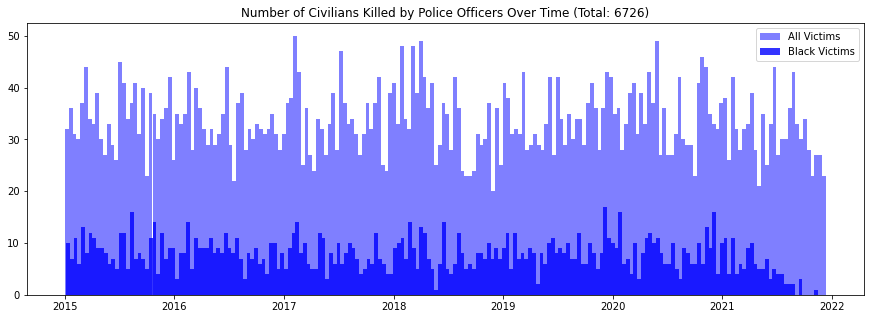

In [11]:
# plotting the histogram of total killings over time to show how brutal the police are, there are multiple killings per day!!!

fig = plt.figure(figsize=(15,5))
axs = fig.add_subplot(1,1,1)
all_killings = axs.hist(killings_df.date, bins = 200, color = 'b', alpha  = 0.5, label = 'All Victims')
black_killings = axs.hist(killings_df[killings_df.race == "B"].date, bins = 200, color = 'b', alpha  = 0.8,label = 'Black Victims')
fig.patch.set_facecolor('xkcd:white')
axs.set_title(f'Number of Civilians Killed by Police Officers Over Time (Total: {len(killings_df)})')
axs.legend()
fig.savefig('killings_over_time', dpi = 300, bbox_inches='tight')

We want to visualize how police brutality disproportionately affects Black people using a pie chart. Since we know that the percentage of police killings is low in Native Americans and Asians, we will group these races into the 'Other' category. We take disproportionality into account by normalizing with the American population by race.

In [12]:
# Keep only W,B and H, the other races are convert to O 
killings_df_race = pd.DataFrame(killings_df.race.replace(['A', 'N'], 'O'))
killings_df_race.race.replace(np.nan, 'O')

0       O
1       W
2       H
3       W
4       H
       ..
6805    O
6806    O
6807    O
6808    O
6809    O
Name: race, Length: 6726, dtype: object

In [13]:
### Population per race in USA in million according to the Washington Post ###
black_pop = 42
white_pop = 197
hispanic_pop = 39
other_pop = 49 
##############

# Normalization
B_killed_per_million = float(killings_df_race[killings_df_race["race"] == 'B'].count()/black_pop)
W_killed_per_million = float(killings_df_race[killings_df_race["race"] == 'W'].count()/white_pop)
H_killed_per_million = float(killings_df_race[killings_df_race["race"] == 'H'].count()/hispanic_pop)
O_killed_per_million = float(killings_df_race[killings_df_race["race"] == 'O'].count()/other_pop)

# Create sub dataframe to plot 
killings_df_prop = {'Race': ['Black', 'Hispanic', 'White', 'Other'], 'Rate': [B_killed_per_million, H_killed_per_million
                                                                  , W_killed_per_million, O_killed_per_million]}  
killings_df_prop = pd.DataFrame(killings_df_prop)

killings_df_prop

,Race,Rate
0,Black,36.952381
1,Hispanic,27.769231
2,White,14.918782
3,Other,4.183673


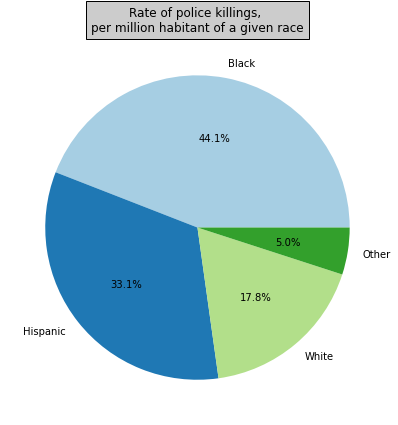

In [14]:
# Creating plot
fig = plt.figure(figsize =(10, 7))
colors = sns.color_palette("Paired")
plt.pie(killings_df_prop.Rate, labels = killings_df_prop.Race, colors = colors,  autopct='%1.1f%%')
plt.title("Rate of police killings, \n" + "per million habitant of a given race", bbox={'facecolor':'0.8', 'pad':5})
# show plot
plt.savefig('generated/armedandunarmed.png')
plt.show()

Once again, we want to see how police brutality manifests even on unarmed individuals. Let's make the same chart for just unarmed inidividuals.

In [15]:
# Taking only unarmed persons killed by US police 
unarmed = killings_df_race.loc[killings_df['armed'] == 'unarmed']

B_killed_per_million = float(unarmed[unarmed["race"] == 'B'].count()/black_pop)
W_killed_per_million = float(unarmed[unarmed["race"] == 'W'].count()/white_pop)
H_killed_per_million = float(unarmed[unarmed["race"] == 'H'].count()/hispanic_pop)
O_killed_per_million = float(unarmed[unarmed["race"] == 'O'].count()/other_pop)

killings_df_prop_unarmed = {'Race': ['Black', 'Hispanic', 'White', 'Other'], 'Rate': [B_killed_per_million, H_killed_per_million
                                                                  , W_killed_per_million, O_killed_per_million]}  
killings_df_prop_unarmed = pd.DataFrame(killings_df_prop_unarmed)

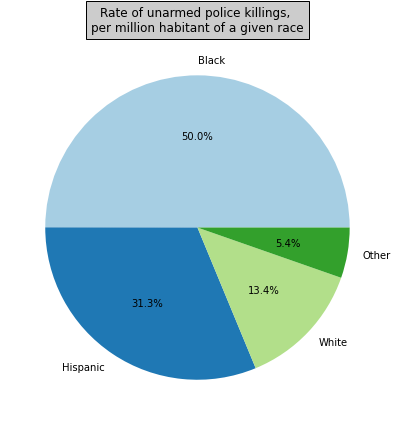

In [16]:
# Creating plot
fig = plt.figure(figsize =(10, 7))
colors = sns.color_palette("Paired")
plt.pie(killings_df_prop_unarmed.Rate, labels = killings_df_prop_unarmed.Race, colors= colors, autopct='%1.1f%%')
plt.title("Rate of unarmed police killings, \n" + "per million habitant of a given race", bbox={'facecolor':'0.8', 'pad':5})
 
plt.savefig('generated/unarmed.png')
# show plot
plt.show()

## Creating the Dataframe for Quotes

df = pd.read_pickle('generated/total-data-merged.pkl.bz2', compression = 'bz2')

In [17]:
df = pd.read_pickle('generated/total-data-merged.pkl.bz2', compression = 'bz2')

In [18]:
# specific keywords that we know if mentioned must relate to the Black Lives Matter movement
specific_keywords = ['alicia garza','all lives matter','alton sterling','anthony hill',
                     'black lives matter','blm','blue lives matter','campaign zero',
                     'eric garner','freddie gray','george zimmerman',"hands up, don't shoot",
                     'movement for black lives','no justice, no peace','patrisse cullors',
                     'philando castile','sandra bland','say her name','stop killing us',
                     'tamir rice','trayvon martin','unarmed black man','white lives matter']

In [19]:
df_specific = df[df.quotation.str.contains('|'.join(specific_keywords), case = False)]

## Quotes Visualization

We now introduce our Quotebank filtered dataset that we obtained from the result of the data_wrangling.ipynb notebook. We want to start visualizing what kind of information we have before diving into more technical analysis. Let's make some wordclouds!

First we need to load spacy.


In [20]:
nlp = spacy.load('en') # spacy in english
all_stopwords = nlp.Defaults.stop_words #saving stopwords

Next, we show the functions we use to create the word clouds. We will have to clean our quotes a bit to really show the most frequent topics, so we remove all stopwords and punctuation. We also lemmatize in case some topics appear in different forms from their root form. Then, we have some functions to create the full text corpus and actually build the word cloud.

In [21]:
def remove_stopwords(doc):
    '''Remove all stopwords from the given doc.'''
    new_doc = [token for token in doc if not token.is_stop]
    return new_doc

def remove_punctuation(doc):
    '''Remove all punctuation from the given doc.'''
    new_doc = [token for token in doc if token.is_alpha]
    return new_doc

def lemmatize(doc):
    '''Lemmatize all words in the given doc.'''
    new_doc = [token.lemma_ for token in doc]
    return new_doc

def create_text(df,column):
    '''Create a text corpus from all the data in a column of a dataframe.'''
    text = []
    for doc in df[column]:
        text += doc
    return text

def create_wordcloud(text):
    '''Create a word cloud from the given text.'''
    wordcloud = WordCloud(background_color = 'white').generate(" ".join(text))
    plt.figure(figsize = (15,15))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

Let's start by making a wordcloud of all quotes that are the most specific to the Black Lives Matter movement. 

In [22]:
docs = list(nlp.pipe(df_specific.quotation)) # creating a spacy doc

In [23]:
# calling all our functions to get our quotes ready for the wordcloud
df_specific_quotes = df_specific.copy()[['quotation']]
df_specific_quotes['spacy_quotation'] = list(docs)
df_specific_quotes['spacy_quotation'] = df_specific_quotes.spacy_quotation.apply(lambda x: remove_stopwords(x))
df_specific_quotes['spacy_quotation'] = df_specific_quotes.spacy_quotation.apply(lambda x: remove_punctuation(x))
df_specific_quotes['spacy_quotation'] = df_specific_quotes.spacy_quotation.apply(lambda x: lemmatize(x))

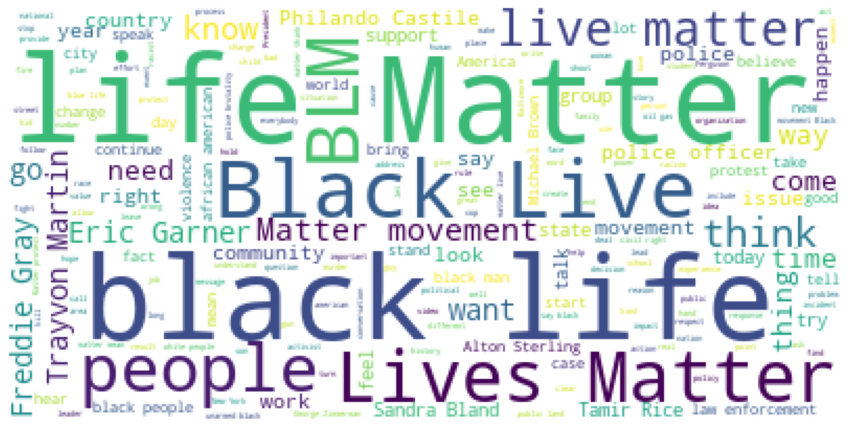

In [24]:
#creatnig the word cloud
full_text = create_text(df_specific_quotes,'spacy_quotation')
create_wordcloud(full_text)

Here, we show a wordcloud of a sample of the entire dataframe. We believe this is representative of the entire dataframe since the quotes selected are a uniform random sample.

In [25]:
#repeat the process for a sample of the data 
df_sample = df.sample(50000)
docs = list(nlp.pipe(df_sample.quotation))
df_quotes = df_sample.copy()[['quotation']]
df_quotes['spacy_quotation'] = list(docs)
df_quotes['spacy_quotation'] = df_quotes.spacy_quotation.apply(lambda x: remove_stopwords(x))
df_quotes['spacy_quotation'] = df_quotes.spacy_quotation.apply(lambda x: remove_punctuation(x))
df_quotes['spacy_quotation'] = df_quotes.spacy_quotation.apply(lambda x: lemmatize(x))

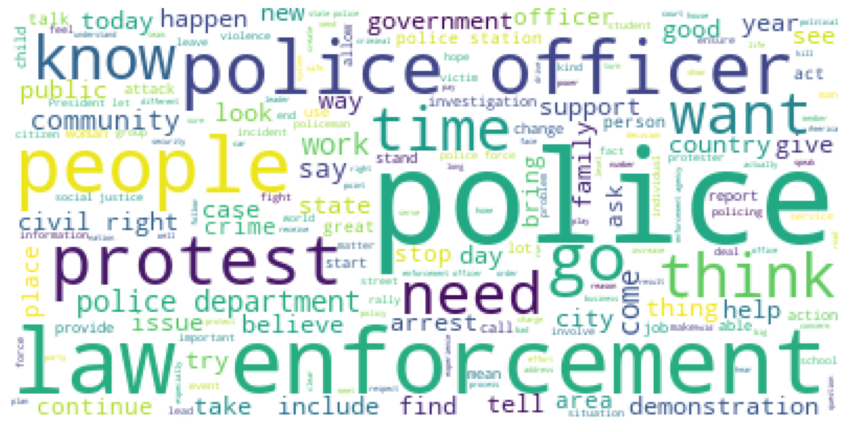

In [26]:
full_text = create_text(df_quotes,'spacy_quotation')
create_wordcloud(full_text)

Finally, let's show the wordcloud when filtering our dataframe by quotes contatining the word 'police.' This is relevant since the BLM movement is critical of police, so it will show what words are associated with police in the media.

In [27]:
#repeat the process for data of police quotes
df_police = df[df.quotation.str.contains('police', case = False)].sample(100000)
docs = list(nlp.pipe(df_police.quotation))
df_police_quotes = df_police.copy()[['quotation']]
df_police_quotes['spacy_quotation'] = list(docs)
df_police_quotes['spacy_quotation'] = df_police_quotes.spacy_quotation.apply(lambda x: remove_stopwords(x))
df_police_quotes['spacy_quotation'] = df_police_quotes.spacy_quotation.apply(lambda x: remove_punctuation(x))
df_police_quotes['spacy_quotation'] = df_police_quotes.spacy_quotation.apply(lambda x: lemmatize(x))

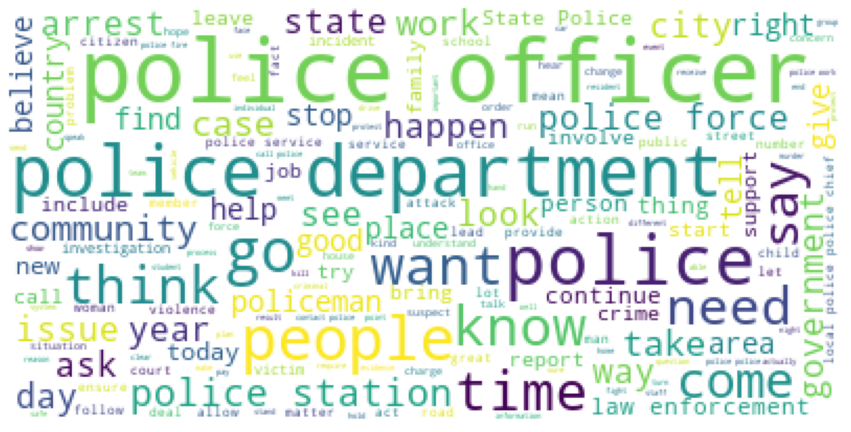

In [28]:
full_text = create_text(df_police_quotes,'spacy_quotation')
create_wordcloud(full_text)